# Prosjekt 1: Datahåndtering og statistikk
_Maruis Børs Lind, Jonas Mayer & Jakob Ruth_ 


### Mål

### Hypotese:
Jeg tror at siden dataene er fra en klokke, at farten og strekningsforskjellen over en kort tid vil være det samme. $V(t)=S'(t)$. Siden det er trangt om plass i en klokke så tror jeg de bruker samme sensor for dette. Jeg tror også at det kommer til å være god korrelasjon mellom puls og høydeendring. Jeg tror også at pulsen kommer til å øke mye i starten av treningsøkten, og deretter stabilisere seg ganske bra etter en liten stund, men med noen svinginger opp og ned.

### Teori:

Hvordan finne R^2 verdi
Derivasjon?

##### Definisjoner:
S = Strenkning (m)\
T = Tid (s) \
V = Hastighet (km/h) \
Hr = Puls (Bpm) \
h = Høyde \
Høydeendring = $\dot{h}$ = h'(t)

### Beskrivelse av data:
Dataene er hentet fra en Garmin forerunner 945 under en rulleskitreningsøkt. Pulsen er samlet inn av et Garmin pulsbelte. Det ble lastet ned som en TCX fil og omgjort til en parquet fil ved hjelp av følgende program: 


In [1]:
'''
import numpy as np
import pylab as plt
import pandas as pd



f = open(r'C:\Skole\Programing\Prosjekt høst\Del 2\activity_17462054947.tcx','rt')
lines = f.readlines()
f.close()

old_time = -1
i=0
data = []
while i<len(lines):
    line = lines[i]
    if line.strip().startswith('<Time>'):
        time = np.datetime64(line.split('<Time>')[1].split('</Time>')[0])
        print(time)
    if line.strip().startswith('<AltitudeMeters>'):
        alt = np.float64(line.split('<AltitudeMeters>')[1].split('</AltitudeMeters>')[0])
        print(alt)
    if line.strip().startswith('<LatitudeDegrees>'):
        lat = np.float64(line.split('<LatitudeDegrees>')[1].split('</LatitudeDegrees>')[0])
        print(lat)
    if line.strip().startswith('<LongitudeDegrees>'):
        long = np.float64(line.split('<LongitudeDegrees>')[1].split('</LongitudeDegrees>')[0])
        print(long)
    if line.strip().startswith('<HeartRateBpm>'):
        i+=1
        line = lines[i]
        hr = np.float64(line.split('<Value>')[1].split('</Value>')[0])
        print(hr)
    if line.strip().startswith('<ns3:Speed>'):
        speed = np.float64(line.split('<ns3:Speed>')[1].split('</ns3:Speed>')[0])
        print(speed)
    if line.strip().startswith('<DistanceMeters>'):
        dist = np.float64(line.split('<DistanceMeters>')[1].split('</DistanceMeters>')[0])
        print(dist)
    if line.strip().startswith('</Trackpoint>'):
        data.append([time, alt, lat, long, dist, speed, hr])
    i+=1

df = pd.DataFrame(data, columns=['Time','Alt' ,'Lat', 'Long', 'Dist','Speed','Hr'])
df.to_parquet(r'C:\Skole\Programing\Prosjekt høst\Del 2\activity_17462054947.parquet')

fig, axs = plt.subplots(3,3,figsize=[8,8])
axs = np.ravel(axs)

ax = axs[0]
ax.plot(df.Time)

for i in [1,2,3,4,5,6]:
    ax = axs[i]
    ax.plot(df.Time, df.iloc[:,i])
    ax.set_title(df.columns[i])
fig.tight_layout()

plt.show()
'''

"\nimport numpy as np\nimport pylab as plt\nimport pandas as pd\n\n\n\nf = open(r'C:\\Skole\\Programing\\Prosjekt høst\\Del 2\x07ctivity_17462054947.tcx','rt')\nlines = f.readlines()\nf.close()\n\nold_time = -1\ni=0\ndata = []\nwhile i<len(lines):\n    line = lines[i]\n    if line.strip().startswith('<Time>'):\n        time = np.datetime64(line.split('<Time>')[1].split('</Time>')[0])\n        print(time)\n    if line.strip().startswith('<AltitudeMeters>'):\n        alt = np.float64(line.split('<AltitudeMeters>')[1].split('</AltitudeMeters>')[0])\n        print(alt)\n    if line.strip().startswith('<LatitudeDegrees>'):\n        lat = np.float64(line.split('<LatitudeDegrees>')[1].split('</LatitudeDegrees>')[0])\n        print(lat)\n    if line.strip().startswith('<LongitudeDegrees>'):\n        long = np.float64(line.split('<LongitudeDegrees>')[1].split('</LongitudeDegrees>')[0])\n        print(long)\n    if line.strip().startswith('<HeartRateBpm>'):\n        i+=1\n        line = lines[i]

Programmet ble ikke laget av meg, men jeg hjalp til med å lage det, og forstår hvordan det fungerer. Programmet går gjennom hver linje i TCX-filen og sjekker om den starter med 'Time', 'AltitudeMeters', 'LatitudeDegrees', 'LongitudeDegrees', 'ns3:Speed' eller 'DistanceMeters' i <> og legger verdien til i hver sin variabel. Deretter legger den til alle varieblene i en liste. Den lager en pandas dataframe og lagrer dataframen som en parquet fil. En parquet fil er en type fil som lagrer dataene på "disken", altså SSD'en i mitt tilfelle, slik som det lagres i minnet. Da går det mye raskere å lese den senere. Her er ikke dette strengt tatt nødevendig, men ved større datasett, så kan dette være en stor fordel. 

#### Oppstart

Importerer de nødvendige bibliotekene

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches

Leser av dataene med pandas

In [3]:
df_raw=pd.read_parquet(r"C:\Skole\Programing\Prosjekt høst\Del 2\activity_17462054947.parquet")

In [4]:
df = df_raw.rename(columns={'Time':'Timestamp'}).drop_duplicates()
df['Time'] = (df.Timestamp-df.Timestamp.min()).dt.total_seconds()

Sjekker de første fem radene og ser etter om alt ser riktig ut, sjekker også infoen til datasettet for å se om alt har riktig formatering.

In [5]:
df.head()

,Timestamp,Alt,Lat,Long,Dist,Speed,Hr,Time
0,2024-11-05 07:56:45,53.200001,59.911312,10.502348,0.00,3.182,110.0,0.0
1,2024-11-05 07:56:46,53.200001,59.911334,10.502327,2.77,3.173,110.0,1.0
2,2024-11-05 07:56:49,53.200001,59.911412,10.502343,11.67,3.061,112.0,4.0
3,2024-11-05 07:56:52,53.599998,59.911486,10.502416,20.85,2.846,115.0,7.0
4,2024-11-05 07:56:55,54.000000,59.911574,10.502415,30.84,2.846,117.0,10.0


In [6]:
df.tail() 

,Timestamp,Alt,Lat,Long,Dist,Speed,Hr,Time
657,2024-11-05 08:32:25,54.799999,59.910723,10.503385,8916.500000,2.389,158.0,2140.0
658,2024-11-05 08:32:32,54.400002,59.910614,10.503617,8934.349609,2.585,156.0,2147.0
659,2024-11-05 08:32:38,54.400002,59.910563,10.503771,8944.919922,2.445,155.0,2153.0
660,2024-11-05 08:32:43,54.200001,59.910564,10.503788,8945.929688,0.159,152.0,2158.0
661,2024-11-05 08:32:44,54.200001,59.910564,10.503790,8945.990234,0.000,152.0,2159.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 0 to 661
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  660 non-null    datetime64[ns]
 1   Alt        660 non-null    float64       
 2   Lat        660 non-null    float64       
 3   Long       660 non-null    float64       
 4   Dist       660 non-null    float64       
 5   Speed      660 non-null    float64       
 6   Hr         660 non-null    float64       
 7   Time       660 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 46.4 KB


### Resultater:

#### Sammenheng mellom $S'(t)$ og $V(t)$

Vi kan starte med å se på om det er en sammenheng mellom avstandsforskjellen fra punkt til punkt delt på tid, og hastighet målt av klokken  $S'(t)\approx\frac{S_0-S_1}{T_0-T_1}$ numerisk tilnærming. Med andre ord avstand derivert med hensyn til tid. $S'(t)$ og $v(t)$ 

In [8]:
df["Speed_from_dist"] = (df.Dist.shift(-1)-df.Dist)/(df.Time.shift(-1)-df.Time)

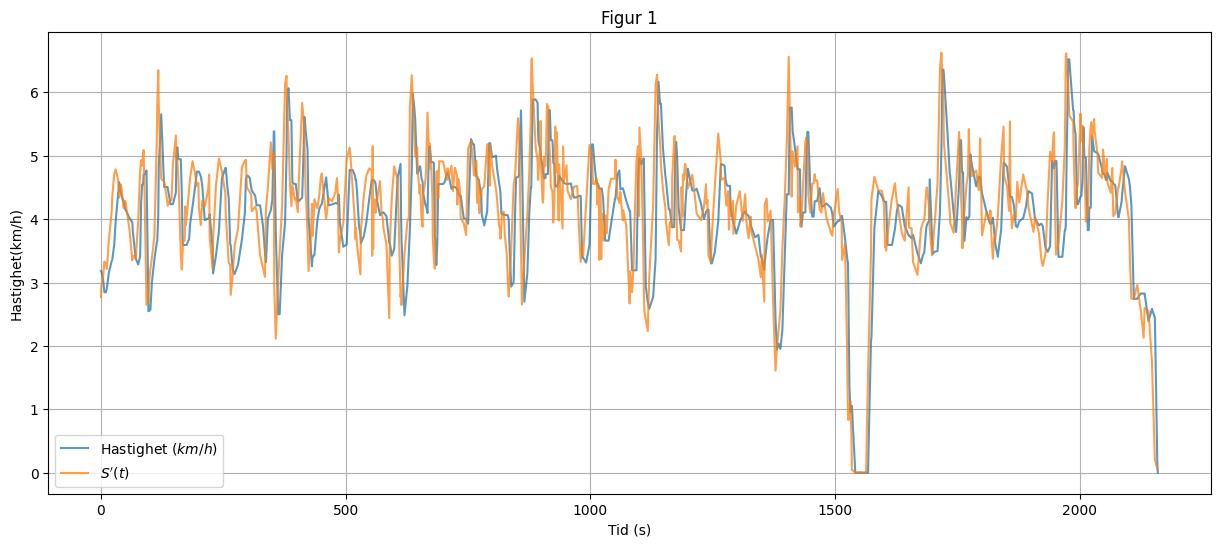

In [9]:
plt.figure(figsize=(15,6))
sns.palette="muted"
sns.lineplot(data=df, x="Time", y="Speed", alpha=0.75, label="Hastighet ($km/h$)")
sns.lineplot(data=df, x="Time", y="Speed_from_dist", alpha=0.75, label="$S'(t)$")
plt.title("Figur 1")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet(km/h)")
plt.legend()
plt.grid()
plt.show()

Ut i fra grafen kan vi se at det er en sammenheng mellom Hastigheten og $S'(t)$, men at de ikke er helt like. Dersom vi plotter punkter gitt ved x= V(t) og y= $S'(t)$ så får vi følgene plott: 

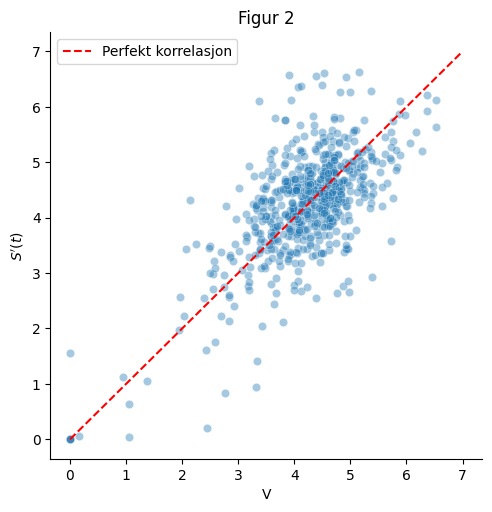

In [10]:
sns.relplot(data=df, x="Speed", y="Speed_from_dist", alpha=0.4)
plt.plot([0,7],[0,7],"r",linestyle="--", label= "Perfekt korrelasjon")
plt.title("Figur 2")
plt.xlabel("V")
plt.ylabel("$S'(t)$")
plt.legend()
plt.show()

Da kan vi se at det er en ganske god sammenheng mellom farten og $S'(t)$. Dette gir mening siden $S'(t)$ bare er et annet utrykk for fart. Ved perfekt korelasjon, altså at $S'(t)$=V(t), så vil r=1 og alle punktene vil ligge på den røde linjen. Da hadde y=x, eller $S'(t)=V(t)$. For å finne korrelasjonskoeffisienten kan vi gjøre en korrelasjonsanalyse, da får vi en korrelasjon på: 

In [11]:
korrelasjon_Speed_Speed_from_dist=df["Speed"].corr(df["Speed_from_dist"])
print("r = ", korrelasjon_Speed_Speed_from_dist)

r =  0.6683399607747841


Det er ikke like bra som forventet, men dersom vi ser tilbake på Figur 1, så ser vi at dataen muligens er forskjøvet. Om vi zoomer mer inn på plottet, så kan vi se at dette stemmer

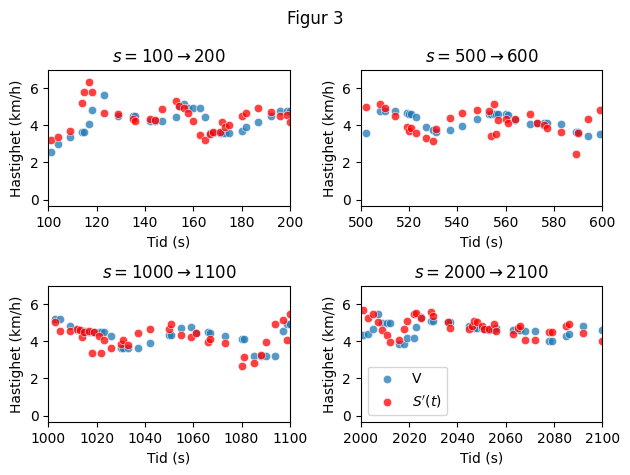

In [12]:
plt.suptitle("Figur 3")

plt.subplot(2,2,1)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x="Time", y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 100 \rightarrow 200$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([100,200])

plt.subplot(2,2,2)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x="Time", y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 500 \rightarrow 600$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([500,600])

plt.subplot(2,2,3)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x="Time", y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 1000 \rightarrow 1100$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([1000,1100])

plt.subplot(2,2,4)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75, label="V")
sns.scatterplot(data=df, x="Time", y="Speed_from_dist", color="red", alpha=0.75, label = "$S'(t)$")
plt.title(r"$ s= 2000 \rightarrow 2100$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([2000,2100])

plt.legend()
plt.gcf().tight_layout()
plt.show()

Det kan se ut som at alle fartspunktene (V, de blå) er forskjøvet med ca 2-3 sekunder. Vi kan teste dette ved: 

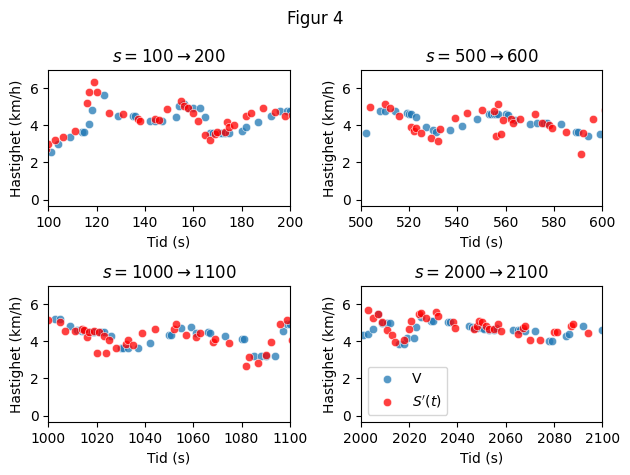

In [13]:
tid_2=df["Time"]+2
plt.suptitle("Figur 4")

plt.subplot(2,2,1)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x=tid_2, y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 100 \rightarrow 200$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([100,200])

plt.subplot(2,2,2)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x=tid_2, y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 500 \rightarrow 600$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([500,600])

plt.subplot(2,2,3)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75)
sns.scatterplot(data=df, x=tid_2, y="Speed_from_dist", color="red", alpha=0.75)
plt.title(r"$ s= 1000 \rightarrow 1100$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([1000,1100])

plt.subplot(2,2,4)
sns.scatterplot(data=df, x="Time", y="Speed", alpha=0.75, label="V")
sns.scatterplot(data=df, x=tid_2, y="Speed_from_dist", color="red", alpha=0.75, label = "$S'(t)$")
plt.title(r"$ s= 2000 \rightarrow 2100$")
plt.xlabel("Tid (s)")
plt.ylabel("Hastighet (km/h)")
plt.xlim([2000,2100])

plt.legend()
plt.gcf().tight_layout()
plt.show()

Vi ser da at det passer mye bedre om vi forskyver $S'(t)$ med to sekunder. Dette kan tyde på at det er et filter for hastigheten, noe som vil senke tiden på målinger, men ikke strekningen. I tilleg så er det flere topper i Figur 1 for $S'(t)$ enn for V. Toppene er også mer ekstreme. Her kan klokken kan da ha bommet på én strekningsverdi, og da får vi en høyere fart. Det gir mening at det blir luket ut i presentasjonen av farten fordi dette gjør at grafen blir litt mer oversiktlig. Hvis vi kjører en korrelasjonsanalyse av $S(t+3)$ og V(t) så får vi: 

In [14]:
korrelasjon_Speed_Speed_from_dist_offsett3=df.Speed_from_dist.shift(2).corr(df["Speed"])
print("r = ", korrelasjon_Speed_Speed_from_dist_offsett3)

r =  0.9055546075563404


Dersom vi forskyver med 3 sek så får vi en korrelasjonskoeffisient på:

In [15]:
korrelasjon_Speed_Speed_from_dist_offsett3=df.Speed_from_dist.shift(3).corr(df["Speed"])
print("r = ", korrelasjon_Speed_Speed_from_dist_offsett3)

r =  0.7928992393082364


Altså passer en forsyvning på 2 sek en mye bedre. Om vi plotter punkter ved x= v(t) og Y=$S(t+2)$ så ser vi at denne passer mye bedre. Spredningen på punktene er betydelig mindre

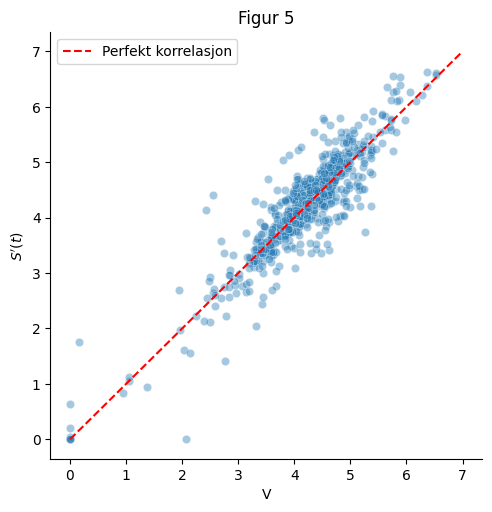

In [16]:
sns.relplot(data=df, x="Speed", y=df.Speed_from_dist.shift(2), alpha=0.4)
plt.plot([0,7],[0,7],"r",linestyle="--", label= "Perfekt korrelasjon")
plt.title("Figur 5")
plt.xlabel("V")
plt.ylabel("$S'(t)$")
plt.legend()
plt.show()

Siden punktene ligger ca gjevnt fordelt på høyre og venstre siden av linjen for perfekt korrelasjon så burde gjennomsnitts verdiene være like. Dette kan vi skjekke ved å utføre hypotesetesting. Koden her er skrevet av AI og modifisert av meg, som en del av en oppgave i timene. Uavhengi utvalg?

In [17]:
t_stat, p_value = stats.ttest_ind(df["Speed"].dropna(), df.Speed_from_dist.shift(2).dropna())

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Vi forkaster nullhypotesen - gjennomsnittene er signifikant forskjellige.")
else:
    print("Vi kan ikke forkaste nullhypotesen - det er ingen signifikant forskjell mellom gjennomsnittene.")

T-statistic: -0.7409924874178608
P-value: 0.45883019030767214
Vi kan ikke forkaste nullhypotesen - det er ingen signifikant forskjell mellom gjennomsnittene.


Dette betyr at de har liknende gjennomsnittsverdi. Gjennomsnitts farten er altså ganske lik S'(t). Vi kan se på forskjellen i gjennomsnitt, standaravvik, Q1, Q2, Q3 og maks verdien ved å bruke describe()

In [18]:
df["Speed"].describe()-df["Speed_from_dist"].shift(2).describe()

count    2.000000
mean    -0.037156
std     -0.069458
min      0.000000
25%      0.004736
50%     -0.039591
75%     -0.085012
max     -0.103000
dtype: float64

Da ser vi at det er relativt liten forskjell mellom hver av dem. Vi ser også at den eneste som er en markant høyere enn alle de andre er maks verdien, dette styrker igjen mistanken om et filter som filtrerer ut verdier som er litt raskere enn alle de andre. Filteret har nok da filtrert ut deler av en topp

#### Sammenheng mellom puls og høydeendring

For å finne en sammenheng mellom puls og høydeendring så kan vi derivere høyden med hensyn på tiden for å finne høydeendringen. Da finner vi høydeforskjellen mellom hvert målingspunkt $\dot{h}=\frac{h_0-h_1}{T_0-T_1}$

In [19]:
df["Height_diff"] = (df.Alt.shift(-1)-df.Alt)/(df.Time.shift(-1)-df.Time)

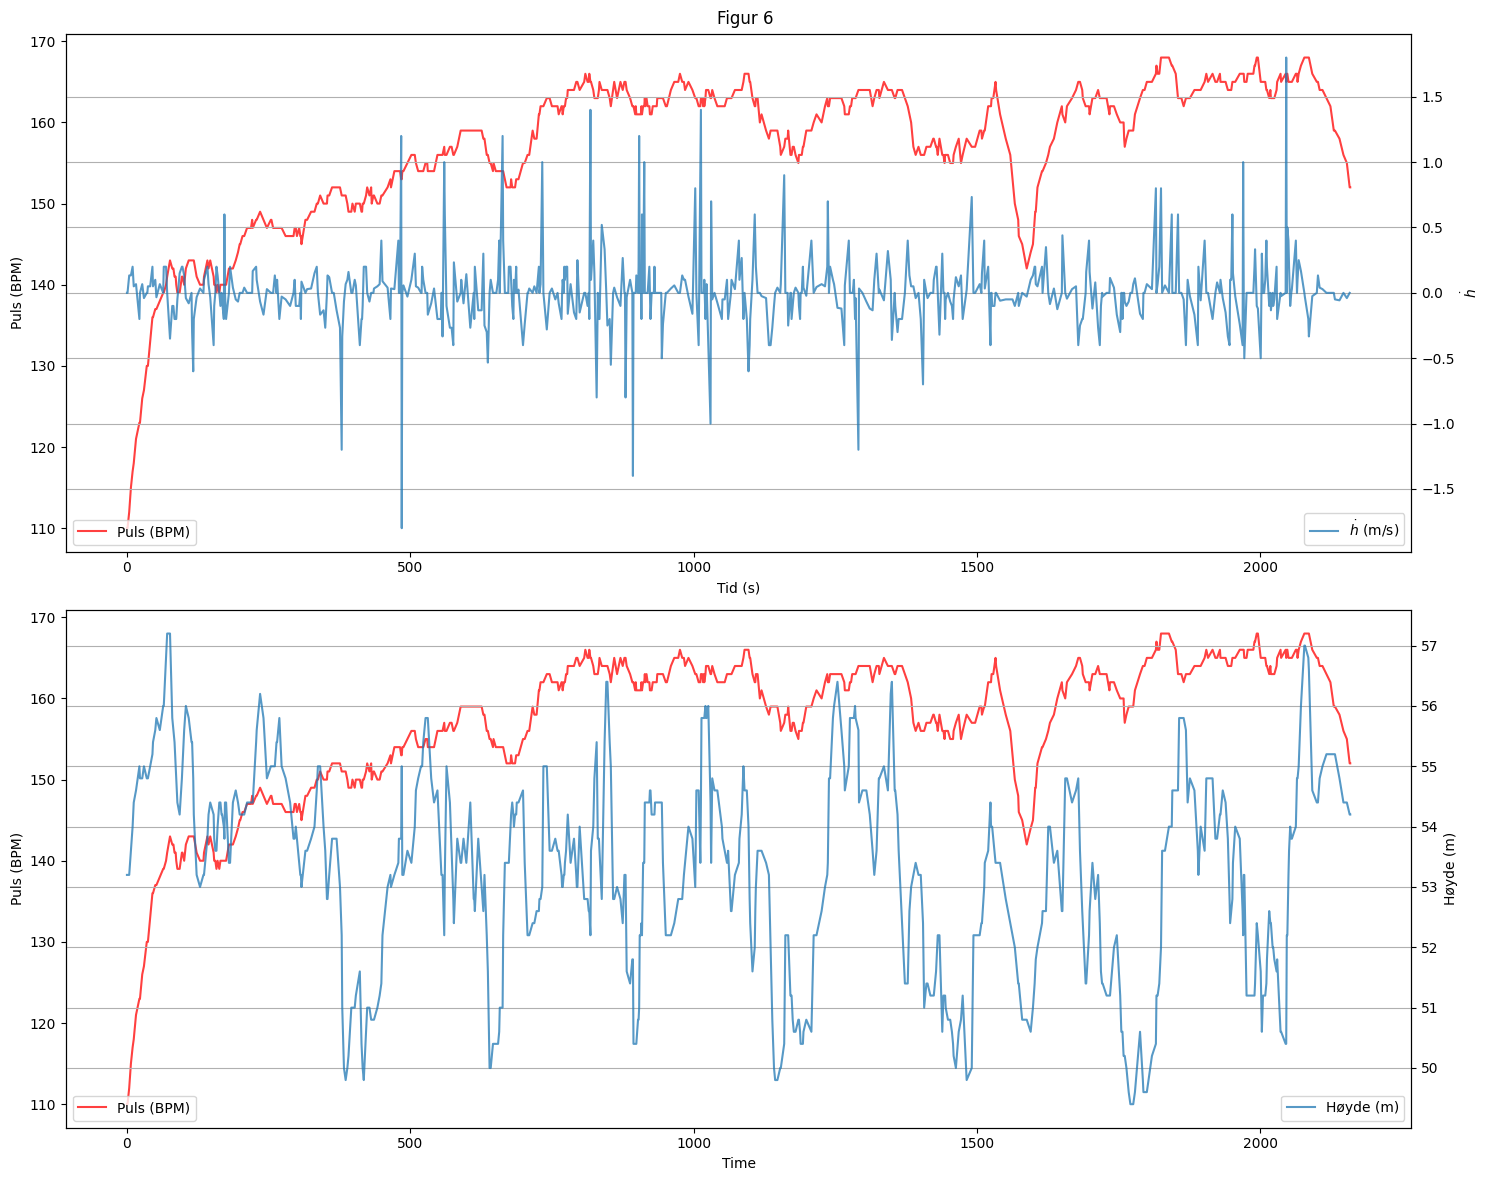

In [20]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15, 12))
plt.suptitle("Figur 6")
sns.lineplot(data=df, x="Time", y="Hr", alpha=0.75, label="Puls (BPM)",color="red", ax=ax1)

ax2 = ax1.twinx()

sns.lineplot(data=df, x="Time", y="Height_diff", alpha=0.75, label="$\dot{h}$ (m/s)",ax=ax2)
plt.grid()
ax1.set_xlabel("Tid (s)")
ax1.set_ylabel("Puls (BPM)")
ax2.set_ylabel("$\dot{h}$")
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")


sns.lineplot(data=df, x="Time", y="Hr", alpha=0.75, label="Puls (BPM)",color="red", ax=ax3)
ax4 = ax3.twinx()

sns.lineplot(data=df, x="Time", y="Alt", alpha=0.75, label="Høyde (m)",ax=ax4)

ax1.set_xlabel("Tid (s)")
ax3.set_ylabel("Puls (BPM)")
ax4.set_ylabel("Høyde (m)")
ax3.legend(loc="lower left")
ax4.legend(loc="lower right")
plt.tight_layout()
plt.grid()
plt.show()

Figur 6 viser puls og høydeendring i samme plot. Her forventet jeg å se at pulsen følger høydeendringen, kanskje litt forskjøvet, men det ser ikke helt sånn ut. Det nederste under i figuren viser høyden og pulsen, det er bare for å gjøre det lettere å visualisere høyden og pulsen opp mot hverandre. For å skjekke om det er en korrelasjon mellom puls og $\dot{h}$ så kan vi se på korrelasjonkoeffisienten

In [21]:
korrelasjon_Hr_h_dot=df["Hr"].corr(df["Height_diff"])
print("r=", korrelasjon_Hr_h_dot)

r= 0.02298079170972745


Det er altså en ganske dårlig korrelasjon mellom puls og $\dot{h}$, men hva med om vi forskyver pulsen?

In [22]:
korrelasjon_Hr_h_dot_shift=[]
for i in range(-20,20):
    korrelasjon_Hr_h_dot_shift.append(df["Hr"].shift(i).corr(df["Height_diff"]))
korrelasjon_Hr_h_dot_shift=np.array(korrelasjon_Hr_h_dot_shift)
print(korrelasjon_Hr_h_dot_shift.argmax(),max(korrelasjon_Hr_h_dot_shift))

9 0.065504235010273


Da får vi at den beste korrelasjonskoeffisienten er $r\approx 0.0655$ ved $i=-20+80=-12$. Dette betyr at det er høyest korrelasjonskoeffisient dersom tiden er forøvet med -12 målinger. Dette kan gi mening, atlså at pulsen stiger litt etter oppoverbakken. Men korrelasjonskoeffisienten er veldig lav. En korrelasjonskeffisient på 1 er en perfekt korrelajson og -1 er negativ korrelasjon. Vi får bare vite at pulsen er forsjøvet, da er det fort gjort å tro at den er forskjøvet med 12 sekunder, men det er ikke nødvendigvis tillfellet

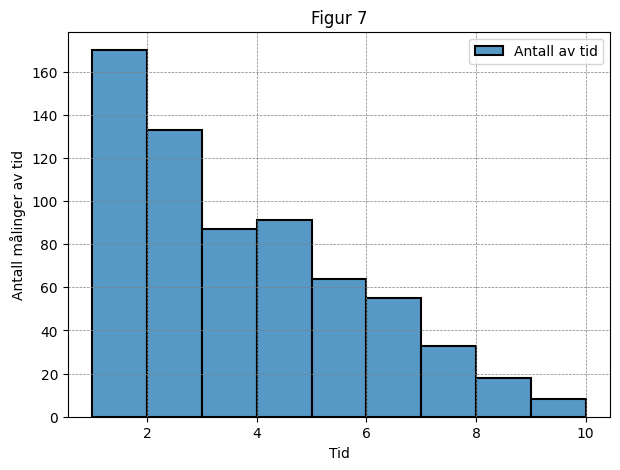

In [23]:
plt.figure(figsize=(7,5))
sns.histplot((df.Time.shift(-1)-df.Time),edgecolor='black', label="Antall av tid", linewidth=1.5, binwidth=1)
plt.xlabel("Tid")
plt.ylabel("Antall målinger av tid")
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=1)
plt.title("Figur 7")
plt.legend()
plt.show()

Figur 7 viser en antall målinger av en gitt tid. Det finnes altså ca. 20 målinger der tidsforskjellen mellom to målinger er 8 sekunder. Så om vi uheldige, så kan de 12 målingene være med åtte sekunder forskjell. Derfor må vi oppgi det i antall målinger. Tiden kan varier fra $12*1s=12s$ til $12*9s=108s$

#### Analyse av puls

BOXPLOT (?)

Figur 8 viser pulsen gitt ved tiden

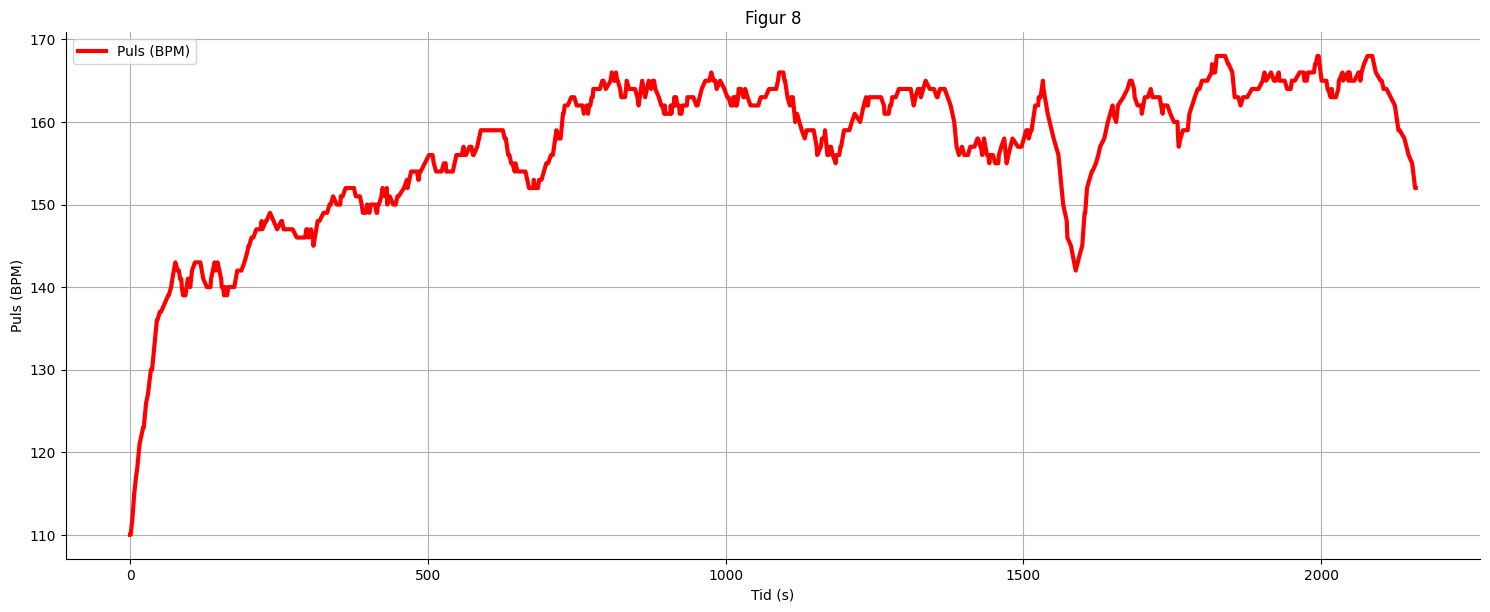

In [24]:
sns.relplot(data=df, x="Time", y="Hr", kind="line", linewidth=3, height=6, aspect=2.5, label="Puls (BPM)", color="red")
plt.legend()
plt.xlabel("Tid (s)")
plt.ylabel("Puls (BPM)")
plt.title("Figur 8")
plt.grid()
plt.show()

Det kan se ut som at en $y = a\cdot ln(x)+b$. Passer bra som en tilnærming, vi kan bruke ChatGPT til å hjelpe med å lage en logaritmisk regresjonsmodell og finne en $R^2$ verdi, programet er redigert av meg:

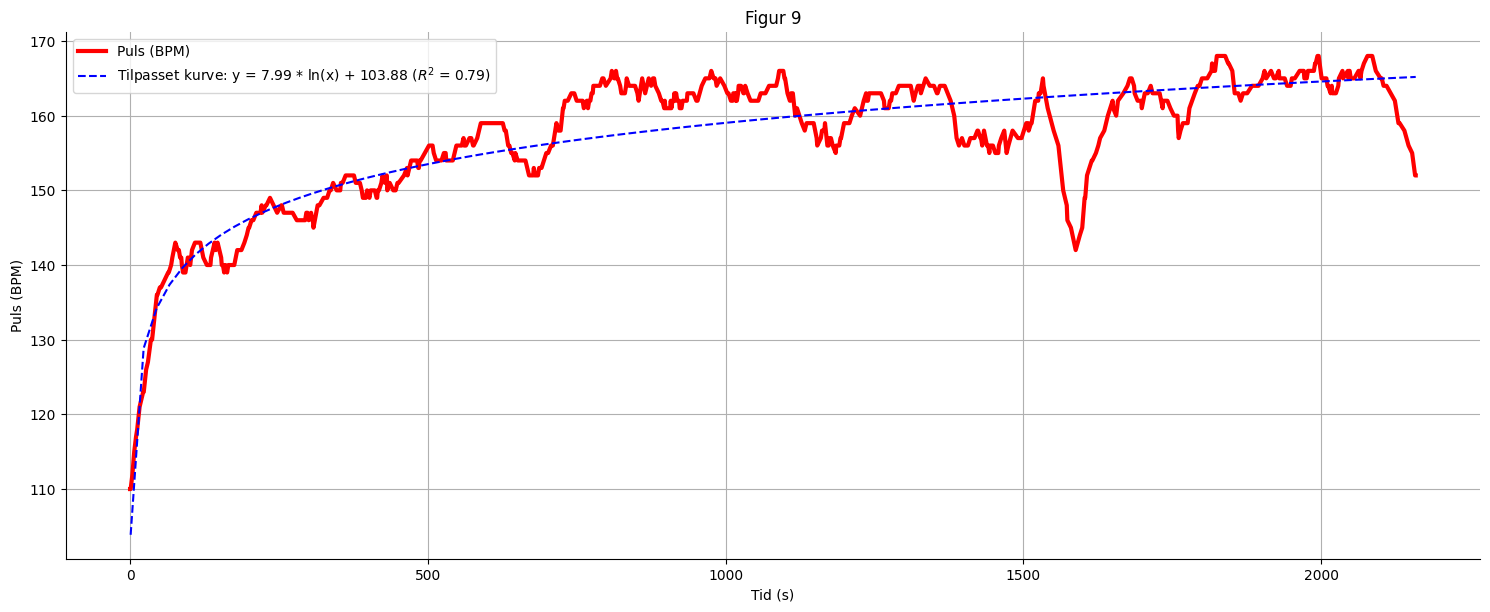

In [25]:
# Define a logarithmic function
def log_func(x, a, b):
    return a * np.log(x) + b

# Fit the curve using curve_fit
x_data = df['Time']
y_data = df['Hr']

# Remove zeros from x_data to avoid log(0)
x_data_no_zeros = x_data[x_data > 0]
y_data_no_zeros = y_data[x_data > 0]

params, covariance = curve_fit(log_func, x_data_no_zeros, y_data_no_zeros)

# Predicted values using the fitted parameters
y_pred = log_func(x_data_no_zeros, *params)

# Calculate R^2
residuals = y_data_no_zeros - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data_no_zeros - np.mean(y_data_no_zeros))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the original data
sns.relplot(data=df, x="Time", y="Hr", kind="line", linewidth=3, height=6, aspect=2.5, label="Puls (BPM)", color="red")
plt.xlabel('Tid (s)')
plt.ylabel('Puls (BPM)')

# Plot the fitted logarithmic curve
x_fit = np.linspace(min(x_data_no_zeros), max(x_data_no_zeros), 100)
y_fit = log_func(x_fit, *params)
plt.plot(x_fit, y_fit, 'b--', label=f'Tilpasset kurve: y = {params[0]:.2f} * ln(x) + {params[1]:.2f} ($R^2$ = {r_squared:.2f})')
plt.legend()
plt.title('Figur 9')
plt.grid()
plt.show()

For å teste om dette er en god modell, så kan vi se på $R^2$ verdien, her finnes det biblioteker som kan gjøre det, men det funket ikke for meg av en eller annen grund, så da spurte jeg ChatGPT om hvordan jeg kunne regne ut $R^2$ verdien. Da jeg skjekket det den skrev med det "Newcastle University" skriver om hvordan man kan vinne en $R^2$ verdi så stemte det godt overens. Her er $R^2=0.79$, dette betyr at modellen passer ganske bra, spesielt med tanke på at dette er virkelige data og da kan det være støy, uteliggende målinger eller liknende som påvirker datasettet. Vi kan se at pulsen stiger en del i starten, men begyner å flate ut mot slutten av treningsøkten. Dette stemmer ganske bra med hypotesen. Videre så kan vi se nøyere på pulsen med et boxplot og beskrivelse av dataene:

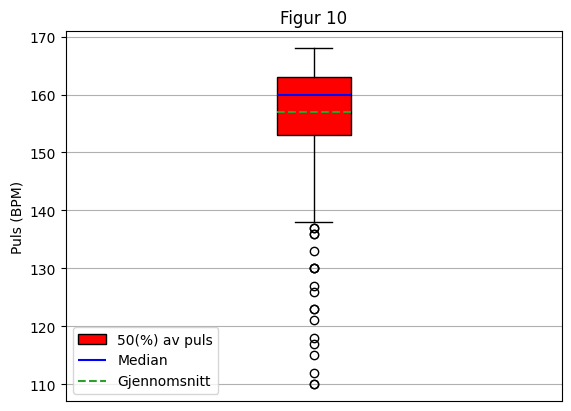

In [140]:
ans=plt.boxplot(df.Hr, showmeans=True, meanline=True, patch_artist=True)
#print(ans["means"][0])
ans["means"][0].set_label("Gjennomsnitt")
ans["means"][0].set_linewidth(1.5)
ans["boxes"][0].set_label("50(%) av puls")
ans["boxes"][0].set_facecolor("red")
ans["medians"][0].set_label("Median")
ans["medians"][0].set_color("blue")
ans["medians"][0].set_linewidth(1.5)
plt.title("Figur 10")
plt.ylabel("Puls (BPM)")
plt.grid()
plt.legend(loc="lower left")
plt.xticks([])
plt.show()

In [61]:
df.Hr.describe()

count    660.000000
mean     156.912121
std        9.226611
min      110.000000
25%      153.000000
50%      160.000000
75%      163.000000
max      168.000000
Name: Hr, dtype: float64

Figur 10 viser et boxplot av pulsen, her ser vi at 50% av dataene ligger innenfor den røde boksen. Disse dataene ligger altså mellom Q1 (25% kvartilen) og Q3 (75% kvartilen) som i dette tilfellet er mellom 153 og 163 BPM. Dette kan tyde på en ganske gjevn puls. Figuren viser også dataene som ligger innenfor 1.5 ganger av interkvartilbredden, dette vises ved "T" formene (engelsk: whisker). Uteliggerdataene er markert med sirkler. På den øvre "T"-formen så er den ikke 1.5 ganger lengre enn interkvartlibredden, fordi det ikke er noen datapunkter som er så høye. Den stopper altså ved enten 1.5 eller maks verdien, den av dem som kommer først. Beskrivelsen av pulsen sier at gjennomsnittspulsen er ca 157 BPM, og det er et standaravvik på 9.22. Minstepulsen er 110 og makspulsen er 168. Median pulsen er lik Q2 som er 160. Det betyr at 50% av dataene er over og 50% er under punktene. Figur 10 viser også medianpulsen og gjenomsnittet

### GPS

For moroskyld så har jeg også plottet GPS sporet under

Her er løypen som ble gått.

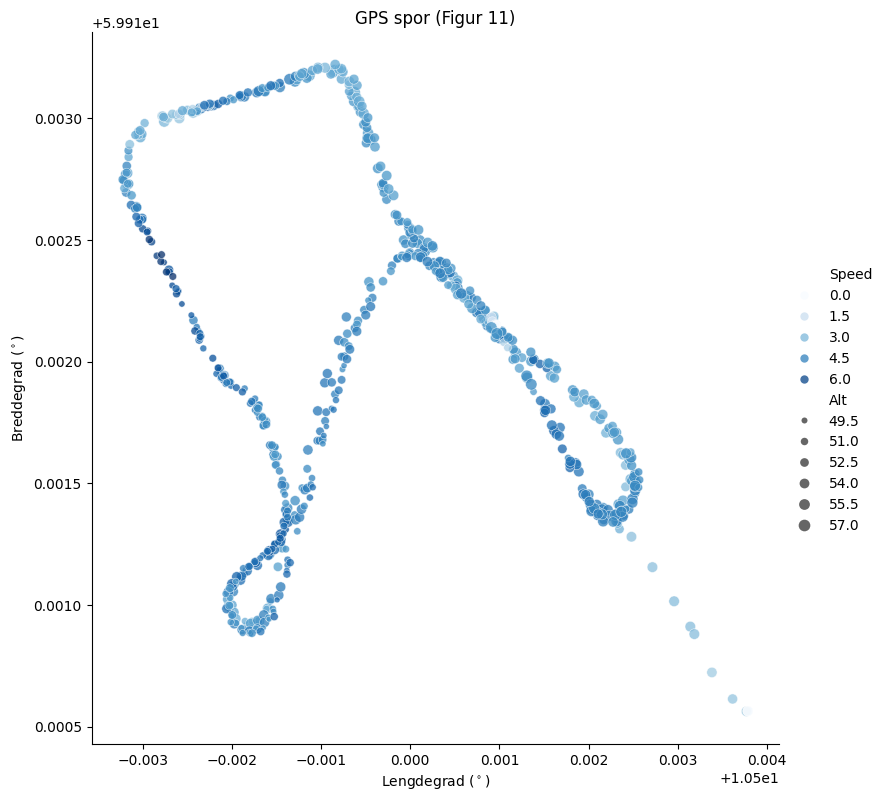

In [32]:
sns.relplot(data=df, x="Long", y="Lat", hue= "Speed", size="Alt", height=8, palette="Blues", label = "GPS spor", alpha=0.75)
plt.title("GPS spor (Figur 11)")
plt.xlabel("Lengdegrad ($^\circ$)")
plt.ylabel("Breddegrad ($^\circ$)")
plt.show()

Her representerer fargen hastigheten, jo mørkere farge jo fortere hastighet og størelsen høydemeter. JEg spurte også ChatGpt om den kunne plotte det i 3D, det kunne den! Figur 11 er et 3D plot og er interaktivt (hvertfall i min jupyter notebook i visual studio code)

In [33]:
import plotly.express as px

# Create a 3D scatter plot
fig = px.scatter_3d(
    df,
    x="Long",
    y="Lat",
    z="Alt",
    color="Speed",
    size="Speed",
    color_continuous_scale="Blues",
    labels={"Long": "Lengdegrad", "Lat": "Breddegrad", "Alt": "Høyde (m)", "Speed": "Hastighet (km/h)"},
    title="GPS spor (Figur 12)"
)

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="Lengdegrad",
        yaxis_title="Breddegrad",
        zaxis_title="Høyde (m)"
    ),
    coloraxis_colorbar=dict(title="Speed"),
    height=800,
    width=1000
)

# Show the plot
fig.show()

### Drøfting

Oppsumering av det jeg har skrevet så langt

### Konlusjon

Hva har jeg gjort og har jeg svart på hypotesen?

### Ekstra (SKAL FJERNES!!):

In [ ]:
assert 1==2

AssertionError: 

In [ ]:
Speed_Speed_from_dist=df[["Speed","Speed_from_dist"]]
#korrelasjon_Speed_Speed_from_dist=Speed_Speed_from_dist.corr()
print("r=",Speed_Speed_from_dist.corr())

In [ ]:
(df.Time.shift(-1)-df.Time).argmin()

In [ ]:
df.loc[140:150,:]